In [1]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 377.4/377.4 kB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 11.1 MB/s eta 0:00:00


In [2]:
# Deutsch–Jozsa Algorithm using Qiskit 2.x
# Compatible with Qiskit >= 2.0.0

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Operator
import matplotlib.pyplot as plt
import numpy as np
import qiskit_aer.noise as noise
from google.colab import userdata
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Session, Options

In [3]:
# ---------- ORACLES ----------
def oracle_constant(qc, ancilla, value=0):
    """Constant oracle: f(x)=0 or f(x)=1"""
    if value == 1:
        qc.x(ancilla)


def oracle_balanced_parity(qc, inputs, ancilla):
    """Balanced oracle: f(x) = x0 XOR x1 XOR ... XOR xn"""
    for q in inputs:
        qc.cx(q, ancilla)


In [4]:
# ---------- DEUTSCH–JOZSA CIRCUIT ----------
def deutsch_jozsa_circuit(n, oracle_func, *oracle_args):
    """
    n: number of input qubits
    oracle_func: oracle function to modify the circuit
    oracle_args: extra arguments for oracle
    """
    qreg = QuantumRegister(n + 1, "q")
    creg = ClassicalRegister(n, "c")
    qc = QuantumCircuit(qreg, creg)

    inputs = list(range(n))
    ancilla = n

    # Step 1: Initialize |0...0>|1>
    qc.x(ancilla)

    # Step 2: Apply Hadamard to all qubits
    qc.h(qreg)
    qc.barrier()

    # Step 3: Oracle
    oracle_func(qc, *oracle_args)
    qc.barrier()

    # Step 4: Apply Hadamard to input qubits
    qc.h(inputs)

    # Step 5: Measure only input qubits
    qc.measure(inputs, creg)

    return qc


In [5]:
# ---------- EXECUTION ----------
def run_dj(qc):
    """Run Deutsch–Jozsa circuit on AerSimulator"""
    simulator = AerSimulator()
    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    print("Measurement counts:", counts)
    plot_histogram(counts)
    plt.show()

    n = qc.num_clbits
    if counts.get("0" * n, 0) == 1024:
        print("✅ Function is CONSTANT")
    else:
        print("✅ Function is BALANCED")


In [6]:
# ---------- MAIN ----------
if __name__ == "__main__":
    n = 3  # number of input qubits

    print("\n=== Constant Oracle (f(x)=0) ===")
    qc_const = deutsch_jozsa_circuit(
        n, oracle_constant, n, 0
    )
    print(qc_const.draw(fold=-1))
    run_dj(qc_const)

    print("\n=== Balanced Oracle (Parity) ===")
    qc_balanced = deutsch_jozsa_circuit(
        n, oracle_balanced_parity, list(range(n)), n
    )
    print(qc_balanced.draw(fold=-1))
    run_dj(qc_balanced)



=== Constant Oracle (f(x)=0) ===
     ┌───┐      ░  ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░──░─┤ H ├┤M├──────
     ├───┤      ░  ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░──░─┤ H ├─╫─┤M├───
     ├───┤      ░  ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░──░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░  ░ └───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░──░───────╫──╫──╫─
     └───┘└───┘ ░  ░       ║  ║  ║ 
c: 3/══════════════════════╩══╩══╩═
                           0  1  2 
Measurement counts: {'000': 1024}
✅ Function is CONSTANT

=== Balanced Oracle (Parity) ===
     ┌───┐      ░                 ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░───■─────────────░─┤ H ├┤M├──────
     ├───┤      ░   │             ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───┼────■────────░─┤ H ├─╫─┤M├───
     ├───┤      ░   │    │        ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───┼────┼────■───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘└───┘ ░       ║  ║  ║ 
c: 3/═══════════════

# ***TASK 1***

In [7]:
def oracle_balanced_custom_task1(qc, inputs, ancilla):
    """
    Implements f(x) = x0 XOR (x1 AND x2) for n=3
    - qc: QuantumCircuit
    - inputs: list of input qubits [q0, q1, q2]
    - ancilla: ancilla qubit index
    """
    # Apply (x1 AND x2) to ancilla using a Toffoli (CCX) gate
    # Flips ancilla if q1=1 and q2=1
    qc.ccx(inputs[1], inputs[2], ancilla)

    # Apply x0 to ancilla using a CNOT (CX) gate
    # Flips ancilla if q0=1
    qc.cx(inputs[0], ancilla)

print("\n--- Task 1: Custom Balanced Oracle ---")
n_task1 = 3
inputs_task1 = list(range(n_task1))
ancilla_task1 = n_task1

# Build the circuit
qc_task1 = deutsch_jozsa_circuit(
    n_task1,
    oracle_balanced_custom_task1,
    inputs_task1,
    ancilla_task1
)

print(qc_task1.draw(fold=-1))
# Run the simulation
run_dj(qc_task1)
# The result will be non-zero, indicating BALANCED.


--- Task 1: Custom Balanced Oracle ---
     ┌───┐      ░            ░ ┌───┐┌─┐      
q_0: ┤ H ├──────░────────■───░─┤ H ├┤M├──────
     ├───┤      ░        │   ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├──────░───■────┼───░─┤ H ├─╫─┤M├───
     ├───┤      ░   │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├──────░───■────┼───░─┤ H ├─╫──╫─┤M├
     ├───┤┌───┐ ░ ┌─┴─┐┌─┴─┐ ░ └───┘ ║  ║ └╥┘
q_3: ┤ X ├┤ H ├─░─┤ X ├┤ X ├─░───────╫──╫──╫─
     └───┘└───┘ ░ └───┘└───┘ ░       ║  ║  ║ 
c: 3/════════════════════════════════╩══╩══╩═
                                     0  1  2 
Measurement counts: {'101': 252, '011': 241, '111': 250, '001': 281}
✅ Function is BALANCED


# ***TASK 2***

In [8]:
print("\n--- Task 2: Varying Number of Qubits ---")

n_list_task2 = [2, 4, 5]

for n_task2 in n_list_task2:
    print(f"\n=== Running for n = {n_task2} input qubits ===")

    # --- Constant Oracle Case ---
    print(f"  --- Constant (f(x)=1) n={n_task2} ---")
    qc_const_task2 = deutsch_jozsa_circuit(
        n_task2, oracle_constant, n_task2, 1
    )
    print(f"  Circuit Depth: {qc_const_task2.depth()}")
    run_dj(qc_const_task2) # Expected: '00...0'

    # --- Balanced Oracle Case ---
    print(f"  --- Balanced (Parity) n={n_task2} ---")
    inputs_task2 = list(range(n_task2))
    ancilla_task2 = n_task2
    qc_bal_task2 = deutsch_jozsa_circuit(
        n_task2, oracle_balanced_parity, inputs_task2, ancilla_task2
    )
    print(f"  Circuit Depth: {qc_bal_task2.depth()}")
    run_dj(qc_bal_task2) # Expected: '11...1'

print("\nObservation: The circuit depth for the parity oracle scales linearly with n")
print("due to the n CNOT gates, while the constant oracle depth is flat.")
print("The output pattern '0...0' (constant) or '1...1' (parity) scales with n.")


--- Task 2: Varying Number of Qubits ---

=== Running for n = 2 input qubits ===
  --- Constant (f(x)=1) n=2 ---
  Circuit Depth: 5
Measurement counts: {'00': 1024}
✅ Function is CONSTANT
  --- Balanced (Parity) n=2 ---
  Circuit Depth: 6
Measurement counts: {'11': 1024}
✅ Function is BALANCED

=== Running for n = 4 input qubits ===
  --- Constant (f(x)=1) n=4 ---
  Circuit Depth: 5
Measurement counts: {'0000': 1024}
✅ Function is CONSTANT
  --- Balanced (Parity) n=4 ---
  Circuit Depth: 8
Measurement counts: {'1111': 1024}
✅ Function is BALANCED

=== Running for n = 5 input qubits ===
  --- Constant (f(x)=1) n=5 ---
  Circuit Depth: 5
Measurement counts: {'00000': 1024}
✅ Function is CONSTANT
  --- Balanced (Parity) n=5 ---
  Circuit Depth: 9
Measurement counts: {'11111': 1024}
✅ Function is BALANCED

Observation: The circuit depth for the parity oracle scales linearly with n
due to the n CNOT gates, while the constant oracle depth is flat.
The output pattern '0...0' (constant) or '1

# ***TASK 3***

In [9]:
def run_dj_noisy_task3(qc, noise_model):
    """Run D-J circuit on a NOISY AerSimulator."""
    simulator = AerSimulator(noise_model=noise_model)

    tqc = transpile(qc, simulator)
    job = simulator.run(tqc, shots=1024)
    result = job.result()
    counts = result.get_counts()

    print("Noisy Measurement counts:", counts)
    # plot_histogram(counts) # Uncomment to show plot
    # plt.show()

    n = qc.num_clbits
    # Get the most frequent outcome
    most_frequent_outcome = max(counts, key=counts.get)

    if most_frequent_outcome == "0" * n:
        print(f"Result (most frequent): Function is CONSTANT")
    else:
        print(f"Result (most frequent): Function is BALANCED")

    if counts.get("0" * n, 0) > 0:
        print(f"   Noise introduced {counts.get('0' * n, 0)} incorrect '000' counts.")


print("\n--- Task 3: Noise Simulation ---")

# 1. Define a simple noise model
noise_model_task3 = noise.NoiseModel()

# Add depolarizing error to 1-qubit gates (Hadamard)
error_1q = noise.depolarizing_error(0.01, 1) # 1% error
noise_model_task3.add_all_qubit_quantum_error(error_1q, ['h'])

# Add depolarizing error to 2-qubit gates (CNOT)
error_2q = noise.depolarizing_error(0.05, 2) # 5% error
noise_model_task3.add_all_qubit_quantum_error(error_2q, ['cx'])

# 2. Build the (n=3, balanced) circuit again
n_task3 = 3
inputs_task3 = list(range(n_task3))
ancilla_task3 = n_task3
qc_bal_task3 = deutsch_jozsa_circuit(
    n_task3, oracle_balanced_parity, inputs_task3, ancilla_task3
)

print(f"Running n={n_task3} balanced (parity) circuit with noise...")
# 3. Run the noisy simulation
run_dj_noisy_task3(qc_bal_task3, noise_model_task3)


--- Task 3: Noise Simulation ---
Running n=3 balanced (parity) circuit with noise...
Noisy Measurement counts: {'100': 1, '010': 3, '000': 12, '001': 28, '110': 20, '101': 21, '011': 39, '111': 900}
Result (most frequent): Function is BALANCED
   Noise introduced 12 incorrect '000' counts.


# ***TASK 4***


--- Task 4: Run on IBM Quantum Device ---


qiskit_runtime_service._discover_account:WARNING:2025-11-04 17:33:05,054: Loading account with the given token. A saved account will not be used.


Authenticating directly with token and instance...
✅ Authentication successful.
   Loaded channel: ibm_quantum_platform

Looking for a backend with >= 4 qubits...
✅ Selected backend: ibm_fez (This is a REAL device!)

Running job on backend (using SamplerV2, no session)...
Job ID: d453hlt2n7pc73eos2vg (You can monitor this on the IBM Quantum website)

Job complete. Results from REAL HARDWARE:
{'000': 1008, '010': 14, '001': 1, '100': 1}
✅ Result (most frequent): Function is CONSTANT


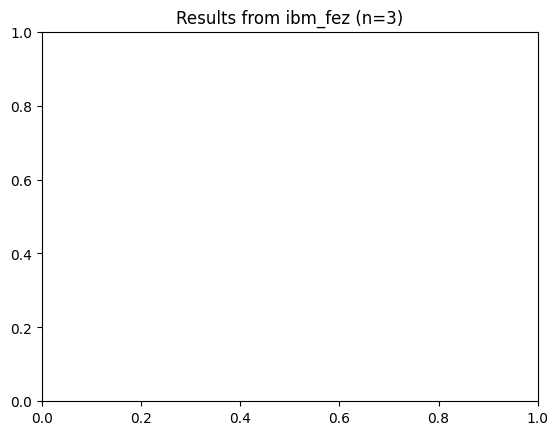

In [13]:
import matplotlib.pyplot as plt
from google.colab import userdata
from qiskit import (
    QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
)
# We are correctly importing SamplerV2
from qiskit_ibm_runtime import (
    QiskitRuntimeService,
    SamplerV2 as Sampler
)
from qiskit.visualization import plot_histogram

# --- Helper Function: Oracle ---
def oracle_balanced_parity(qc, inputs, ancilla):
    """Balanced oracle: f(x) = x0 XOR x1 XOR ... XOR xn"""
    for q in inputs:
        qc.cx(q, ancilla)

# --- Helper Function: Circuit Builder (for Sampler V2) ---
def build_dj_circuit_for_sampler_v2(n, oracle_func, *oracle_args):
    """
    Builds a D-J circuit *without* final measurements
    for use with the SamplerV2 primitive.
    """
    qreg = QuantumRegister(n + 1, "q")
    qc = QuantumCircuit(qreg)
    inputs = list(range(n))
    ancilla = n
    qc.x(ancilla)
    qc.h(qreg)
    qc.barrier()
    oracle_func(qc, *oracle_args)
    qc.barrier()
    qc.h(inputs)
    return qc

# --- Main Task 4 Function ---
def run_task_4_on_ibm():
    print("\n--- Task 4: Run on IBM Quantum Device ---")

    # --- 1. Authenticate using Colab Secret ---
    try:
        my_token = userdata.get('IBM_API_KEY')
        if not my_token:
            print("❌ Error: 'IBM_API_KEY' not found in Colab secrets.")
            return

        print("Authenticating directly with token and instance...")
        service = QiskitRuntimeService(
            channel="ibm_quantum_platform",
            token=my_token,
            instance="open-instance"
        )
        print("✅ Authentication successful.")
        print(f"   Loaded channel: {service.channel}")

    except Exception as e:
        print(f"❌ Authentication failed: {e}")
        return

    # --- 2. Choose a Backend (MANUAL METHOD) ---
    n_task4 = 3 # The number of *input* qubits
    min_qubits = n_task4 + 1 # Total qubits needed (n + 1 ancilla)

    print(f"\nLooking for a backend with >= {min_qubits} qubits...")

    try:
        all_backends = service.backends()
        suitable_backends = []
        for b in all_backends:
            if (not b.simulator) and b.status().operational and b.num_qubits >= min_qubits:
                suitable_backends.append(b)

        if not suitable_backends:
            print("❌ Error: No suitable REAL HARDWARE backends were found.")
            return

        backend = suitable_backends[0]
        print(f"✅ Selected backend: {backend.name} (This is a REAL device!)")

    except Exception as e:
        print(f"❌ Could not find a suitable backend: {e}")
        return

    # --- 3. Build the circuit (without measurements) ---
    inputs_task4 = list(range(n_task4))
    ancilla_task4 = n_task4
    qc_task4_sampler = build_dj_circuit_for_sampler_v2(
        n_task4, oracle_balanced_parity, inputs_task4, ancilla_task4
    )

    # Transpile the circuit
    qc_transpiled_task4 = transpile(qc_task4_sampler, backend)

    # --- 4. Set up and Run with SamplerV2 ---
    print("\nRunning job on backend (using SamplerV2, no session)...")
    try:
        # Initialize SamplerV2 by passing the backend object
        # to the 'mode' parameter.
        sampler = Sampler(mode=backend)

        # Create a new ClassicalRegister and NAME it 'meas'
        creg = ClassicalRegister(n_task4, name="meas")

        # Add it to the circuit
        qc_transpiled_task4.add_register(creg)

        # Map the qubits [0, 1, 2] to the classical register 'creg'
        qc_transpiled_task4.measure(list(range(n_task4)), creg)

        # The 'pub' is just the circuit itself
        pub = qc_transpiled_task4

        # The 'run' method just takes a *list* of pubs
        job = sampler.run([pub], shots=1024)

        print(f"Job ID: {job.job_id()} (You can monitor this on the IBM Quantum website)")
        job_result = job.result()

        # --- 5. Get and interpret results ---
        print("\nJob complete. Results from REAL HARDWARE:")

        # *** THIS IS THE FIX (based on your IBM comment) ***
        # Access the first pub result (index 0), then its data,
        # then the register by name ('meas'), and call get_counts().
        counts = job_result[0].data.meas.get_counts()

        print(counts)

        most_frequent = max(counts, key=counts.get)
        if most_frequent == "0" * n_task4: # Check for '000'
            print("✅ Result (most frequent): Function is CONSTANT")
        else:
            print("✅ Result (most frequent): Function is BALANCED")

        plot_histogram(counts) # Plot the counts dictionary
        plt.title(f"Results from {backend.name} (n={n_task4})")
        plt.show()

    except Exception as e:
        print(f"❌ Job failed: {e}")

# --- Execute the Task 4 function ---
run_task_4_on_ibm()

# ***TASK 5***

In [14]:
print("\n--- Task 5: Circuit Analysis (n=1) ---")

n_task5 = 1
inputs_task5 = [0] # q0
ancilla_task5 = 1  # q1

# 1. Build *only* the oracle circuit
qc_oracle_task5 = QuantumCircuit(n_task5 + 1)
oracle_balanced_parity(qc_oracle_task5, inputs_task5, ancilla_task5)

print("Oracle circuit definition (f(x)=x):")
print(qc_oracle_task5.draw(output="text"))

print("\nQiskit circuit definition (as requested by hint):")
print(qc_oracle_task5.to_gate(label="Uf_n1").definition)

# 2. Get the Unitary Matrix
op_task5 = Operator(qc_oracle_task5)
print("\nUnitary Matrix (Operator) of this oracle:")
# Qiskit qubit order is [q1, q0]
# Basis states: |00>, |01>, |10>, |11>
print(op_task5.data)

print("\n--- Explanation ---")


--- Task 5: Circuit Analysis (n=1) ---
Oracle circuit definition (f(x)=x):
          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

Qiskit circuit definition (as requested by hint):
          
q_0: ──■──
     ┌─┴─┐
q_1: ┤ X ├
     └───┘

Unitary Matrix (Operator) of this oracle:
[[1.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]]

--- Explanation ---
